In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
%config InlineBackend.figure_format = 'retina'

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from model import *
import sys 
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR
from loss_function import *

In [11]:
data_model = diffusion_equation()
dataset = data_model.generate_training_data(500, 10, dlt_t = 0.001)

In [12]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam

data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Define a simple model with a single trainable parameter `k`
class SimpleModel(nn.Module):
    def __init__(self, k_value = None):
        super(SimpleModel, self).__init__()
        if k_value is None:
            self.k = nn.Parameter(torch.randn((), dtype=torch.float64))
        else:
            self.k = nn.Parameter(torch.tensor(k_value, dtype=torch.float64))  # Initialize k as a parameter

    def forward(self, lace_1, lace_2):
        g = lace_1
        h = self.k * lace_1 + lace_2
        return g, h

model = SimpleModel()

In [13]:
data_loader = DataLoader(dataset, batch_size=18000, shuffle=True)
for batch in data_loader:
    x, y, lace_1, lace_2 = batch
    break

In [14]:
lambda_1, lambda_2 = 0, 1
def loss_function(y, g, h):
    N = h.shape[0]
    loss_1 = terminal_loss_ver2(g, h, y)
    loss_2 = orthogonal_loss_ver2(g, h)
    return lambda_1 * loss_1 + lambda_2 * loss_2, loss_1, loss_2

def train_one_epoch(model, optimizer, scheduler, train_loader, loss_fn, epoch, writer):
    model.train()  # Set model to training mode
    total_loss = 0.0

    # Iterate over batches
    for batch_idx, batch in enumerate(train_loader):
        optimizer.zero_grad()  # Clear gradients

        x, y, lace_1, lace_2 = batch

        # Compute g and h using your model. This is model-specific and might look different.
        g, h = model(lace_1, lace_2)

        # Compute the custom loss
        loss = loss_fn(y - x, g, h)[0]

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch_idx % 10 == 0:
            writer.add_scalar('Batch Loss', loss.item(), epoch * len(train_loader) + batch_idx)

        # Track gradients
        for name, param in model.named_parameters():
            if param.grad is not None:
                writer.add_histogram(f'{name}.grad', param.grad, epoch)

    scheduler.step()
    avg_loss = total_loss / len(train_loader)
    print(f"Training Epoch: {epoch + 1}, Average Loss: {avg_loss:.4e}")
    writer.add_scalar('Training Loss', avg_loss, epoch)
    return avg_loss


In [28]:
g = lace_1
h = lace_2

In [20]:
# g, h = model(lace_1, lace_2)
# x = x.reshape(-1, 1)
# y = y.reshape(-1, 1)
# g = g.reshape(-1, 1)
# h = h.reshape(-1, 1)
# gh = torch.cat([g, h], dim=1)
# q, _ = torch.linalg.qr(gh)
# print(gh.shape)
# print(q.shape)

In [21]:
# import matplotlib.pyplot as plt
# plt.hist(lace_1.numpy().flatten(), bins=100)

In [22]:
# epsilon = 1e-6
# plt.hist(epsilon * lace_1.numpy().flatten(), bins=100)

In [23]:
# print(model.k)
# print(loss_function(y, g, h))

In [24]:
# k = 1
# epsilon = 1e-7
# h = lace_1
# g_1 = lace_1 + k * lace_2
# g_2 = lace_1 + (k + epsilon) * lace_2
# N = h.shape[0]
# h_orthogonal = h / (torch.dot(h.squeeze(), h.squeeze())/N + 1e-4)
# print(h_orthogonal)
# # print(g_1 * h)
# print(g_1 * h_orthogonal - g_2 * h_orthogonal)
# e_1 = orthogonal_loss(g_1, h_orthogonal)
# e_2 = orthogonal_loss(g_2, h_orthogonal)
# print(e_1, e_2)
# print(e_2 - e_1)

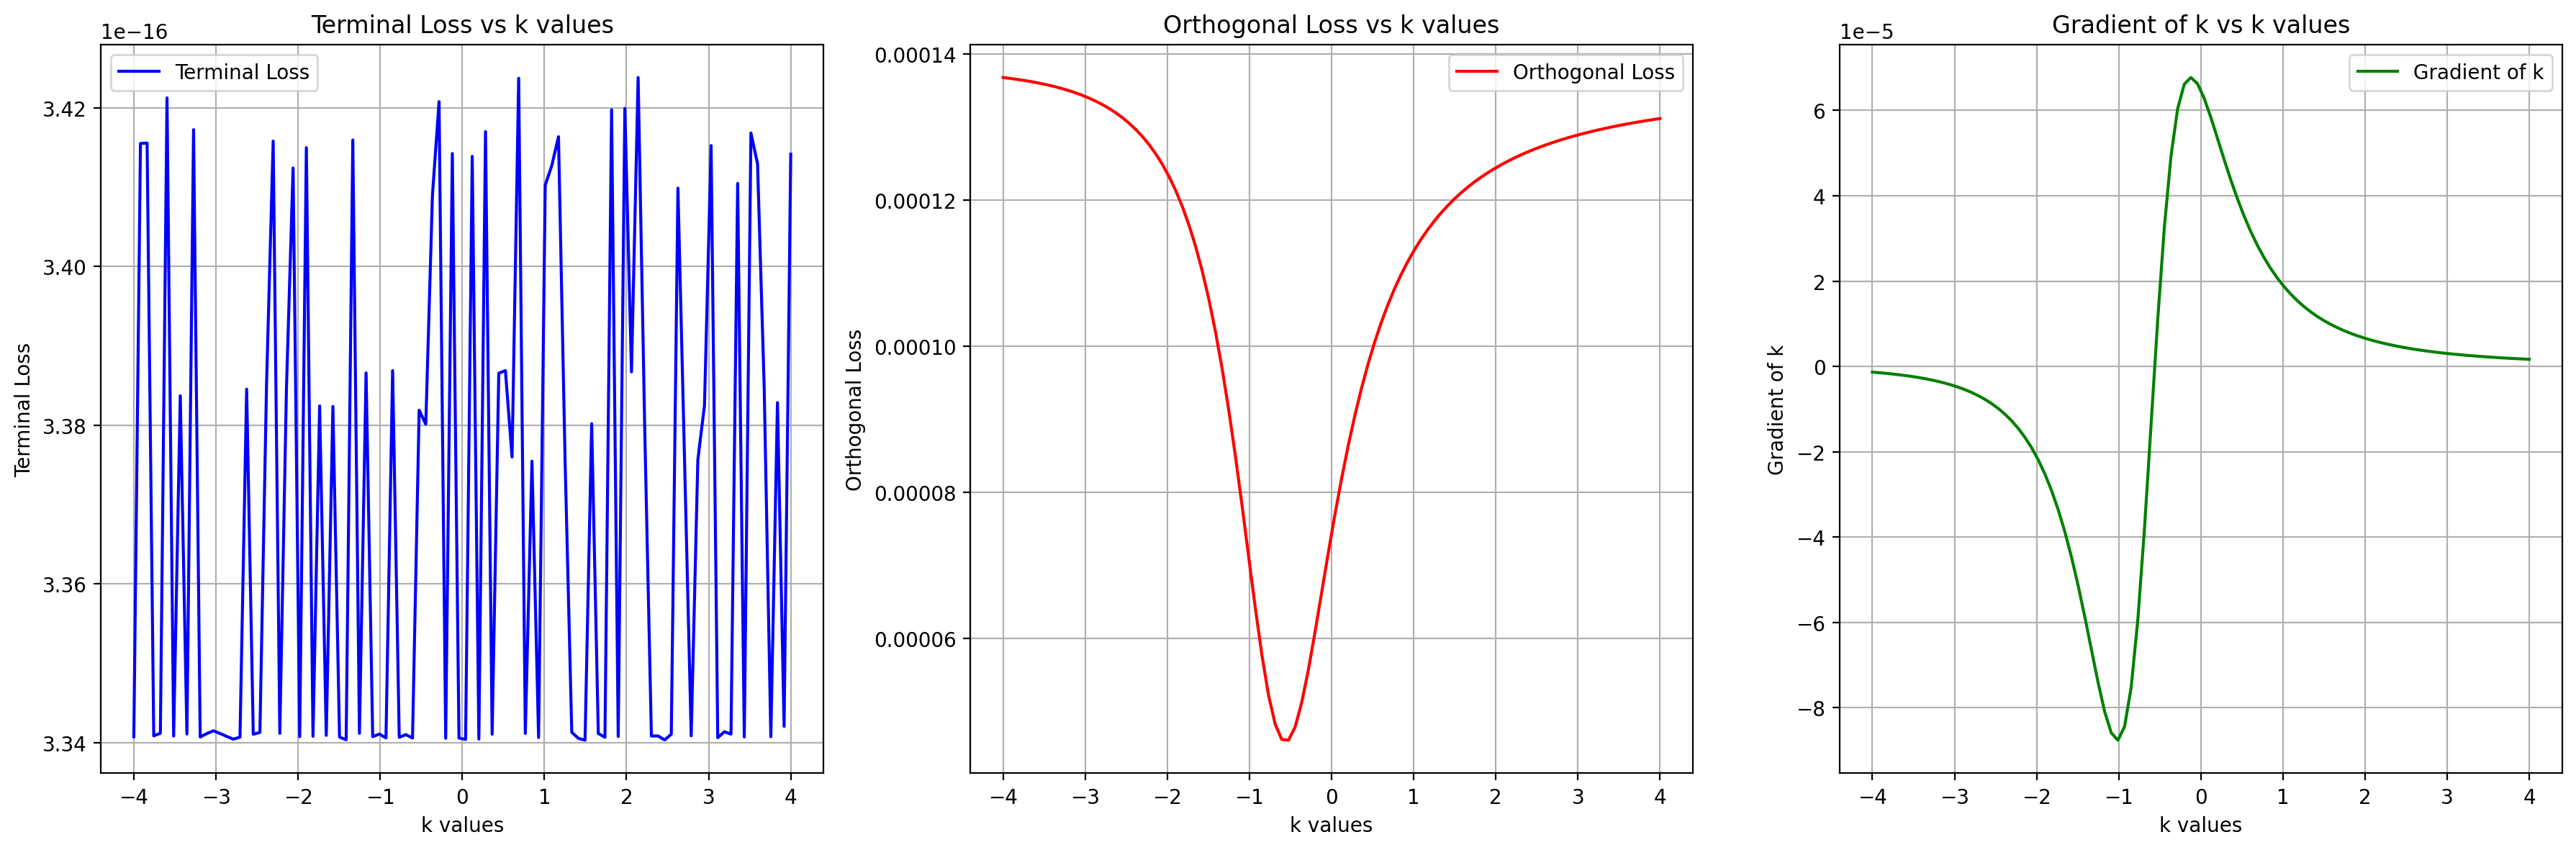

In [21]:
# Define the range of k values to explore
k_values = np.linspace(-4, 4, 100)
terminal_losses = []
orthogonal_losses = []
k_grads = []
k_grads_forward = []
epsilon = 1e-6

# Iterate over k values and compute the loss
for k in k_values:
    # print(k)
    model = SimpleModel(k)
    g, h = model(lace_1, lace_2)
    
    loss, loss_1, loss_2 = loss_function(y - x, g, h)
    terminal_losses.append(loss_1.item())
    orthogonal_losses.append(loss_2.item())
    model.zero_grad()
    loss.backward()
    
    k_grad = model.k.grad.item()
    k_grads.append(k_grad)

    # Compute the gradient using finite differences
    model_plus = SimpleModel(k + epsilon)
    g_plus, h_plus = model_plus(lace_1, lace_2)
    loss_plus, _, _ = loss_function(y, g_plus, h_plus)
    # print(loss_plus.item())
    model_minus = SimpleModel(k - epsilon)
    g_minus, h_minus = model_minus(lace_1, lace_2)
    loss_minus, _, _ = loss_function(y, g_minus, h_minus)
    # print(loss_minus.item())
    k_grad_forward = (loss_plus.item() - loss_minus.item()) / (2 * epsilon)
    k_grads_forward.append(k_grad_forward)
    # # break



# Plotting the results in two subfigures
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Terminal Loss
ax1.plot(k_values, terminal_losses, label='Terminal Loss', color='blue')
ax1.set_xlabel('k values')
ax1.set_ylabel('Terminal Loss')
ax1.set_title('Terminal Loss vs k values')
ax1.legend()
ax1.grid(True)

# Orthogonal Loss
ax2.plot(k_values, orthogonal_losses, label='Orthogonal Loss', color='red')
ax2.set_xlabel('k values')
ax2.set_ylabel('Orthogonal Loss')
ax2.set_title('Orthogonal Loss vs k values')
ax2.legend()
ax2.grid(True)

ax3.plot(k_values, k_grads, label='Gradient of k', color='green')
ax3.set_xlabel('k values')
ax3.set_ylabel('Gradient of k')
ax3.set_title('Gradient of k vs k values')
ax3.legend()
ax3.grid(True)


plt.tight_layout()
plt.show()


In [17]:
k = 0
model = SimpleModel(k)
g, h = model(lace_1, lace_2)
print(y)

# print(g.shape, h.shape)
print(g, h)
# print(lace_1, lace_2)

tensor([[0.9821],
        [0.4589],
        [0.5883],
        ...,
        [0.3680],
        [0.9236],
        [0.9228]])
tensor([[-0.6804],
        [ 0.1476],
        [-0.6559],
        ...,
        [ 0.7526],
        [-0.8853],
        [-1.3212]]) tensor([[-0.5594],
        [ 0.1071],
        [-0.6035],
        ...,
        [ 0.0254],
        [-1.1790],
        [-1.2690]], grad_fn=<AddBackward0>)


In [19]:
# y = g + h
yy = torch.cat([x, g, h], dim=1)
print(yy)
y_orthogonal = gram_schmidt(yy)
coeffs, _, _, _ = torch.linalg.lstsq(y_orthogonal, y)
print(coeffs)

y_proj = torch.matmul(y_orthogonal, coeffs)
print(y_proj)
print(y)

tensor([[ 0.9833, -0.6804, -0.5594],
        [ 0.4586,  0.1476,  0.1071],
        [ 0.5896, -0.6559, -0.6035],
        ...,
        [ 0.3672,  0.7526,  0.0254],
        [ 0.9257, -0.8853, -1.1790],
        [ 0.9254, -1.3212, -1.2690]], grad_fn=<CatBackward0>)
tensor([[7.6679e+01],
        [1.2939e-01],
        [6.9888e-02]], grad_fn=<LinalgLstsqBackward0>)
tensor([[0.9821],
        [0.4589],
        [0.5883],
        ...,
        [0.3680],
        [0.9236],
        [0.9228]], grad_fn=<MmBackward0>)
tensor([[0.9821],
        [0.4589],
        [0.5883],
        ...,
        [0.3680],
        [0.9236],
        [0.9228]])


In [20]:
orthogonal_loss_ver2(g, h)

tensor(7.4298e-05, grad_fn=<SumBackward0>)